# ETL for the stroke dataset

In [1]:
# import the usual and .csv file
import pandas as pd
import numpy as np

over_25_df = pd.read_csv('over_25_subset.csv')
over_25_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_groups
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65s
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,33.2,never smoked,1,55s
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,75s
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,45s
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,75s


In [27]:
over_25_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000
mean,37181.974853,52.995185,0.120653,0.066613,109.154042,30.753103,0.066078
std,21050.228452,16.012438,0.325767,0.249384,48.508031,7.136936,0.248452
min,84.000000,25.000000,0.000000,0.000000,55.220000,11.300000,0.000000
25%,18761.500000,40.000000,0.000000,0.000000,77.327500,26.000000,0.000000
50%,37727.000000,53.000000,0.000000,0.000000,92.655000,29.600000,0.000000
75%,55417.500000,65.000000,0.000000,0.000000,116.910000,34.375000,0.000000
max,72918.000000,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


## Create dataframe subsets to use as tables

In [2]:
demographics_df = pd.DataFrame(over_25_df[['id', 'gender', 'age', 'ever_married','work_type','Residence_type','smoking_status']])
medical_df = pd.DataFrame(over_25_df[['id','hypertension','heart_disease','avg_glucose_level','bmi','stroke']])

In [3]:
demographics_df.head()

,id,gender,age,ever_married,work_type,Residence_type,smoking_status
0,9046,Male,67.0,Yes,Private,Urban,formerly smoked
1,51676,Female,61.0,Yes,Self-employed,Rural,never smoked
2,31112,Male,80.0,Yes,Private,Rural,never smoked
3,60182,Female,49.0,Yes,Private,Urban,smokes
4,1665,Female,79.0,Yes,Self-employed,Rural,never smoked


In [4]:
medical_df.head()

,id,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,9046,0,1,228.69,36.6,1
1,51676,0,0,202.21,33.2,1
2,31112,0,1,105.92,32.5,1
3,60182,0,0,171.23,34.4,1
4,1665,1,0,174.12,24.0,1


### Create CSV files from the new dataframes

In [6]:
demographics_df.to_csv('demographics.csv', index=False)
medical_df.to_csv('medical.csv', index=False)

## Connecting to Postgres

In [5]:
import psycopg2

In [9]:
# saved passwords (in gitignore) read in
from postgres_keys import june_password

### Creating functions for creating the database and the tables

In [10]:
# create a function to create our database
def create_database(db, users, pw, hosts):
    conn = psycopg2.connect(database=db, user=users, password=pw, host=hosts)
    conn.autocommit = True
    
    #Creating a cursor object using the cursor() method
    cur = conn.cursor()
    
    #Preparing query to create a database
    sql = '''CREATE database strokes''';
    
    #Creating a database
    cur.execute(sql)
    print("Database created successfully........")
    
    #Closing the connection
    conn.close()

In [21]:
# create a function to access the new database and create tables
def create_tables(db, users, pw, hosts):
    conn = psycopg2.connect(database=db, user=users, password=pw, host=hosts)
    
    cur=conn.cursor()
    
    cur.execute("""DROP TABLE IF EXISTS demographics""")
    cur.execute("""
    CREATE TABLE demographics(
    ID text PRIMARY KEY,
    gender text,
    age float,
    ever_married text,
    work_type text,
    residence_type text,
    smoking_status text)""")
    conn.commit()
    
    with open('demographics.csv', 'r') as f:
        # Notice that we don't need the `csv` module.
        next(f) # Skip the header row.
        cur.copy_from(f, 'demographics', sep=',')
        
    conn.commit()
    
    cur.execute("""DROP TABLE IF EXISTS medical""")
    cur.execute("""
    CREATE TABLE medical(
    ID text PRIMARY KEY,
    hypertension int,
    heart_disease int,
    avg_glucose_level float,
    bmi float,
    stroke int)""")
    
    with open ('medical.csv', 'r') as f:
        next(f)
        cur.copy_from(f, 'medical', sep=',')
        
    conn.commit()

In [12]:
create_database('postgres', 'postgres', june_password, 'localhost')

Database created successfully........


In [22]:
create_tables('strokes', 'postgres', june_password, 'localhost')

### Query to verify it's working

In [29]:
conn = psycopg2.connect(database='strokes', user='postgres', password=june_password, host='localhost')
    
cur=conn.cursor()

cur.execute("""SELECT d.gender, d.age, m.bmi
    FROM demographics as d
    JOIN medical as m
    ON d.id = m.id
    WHERE m.bmi BETWEEN 18.5 and 24.9;""")
cur.fetchall()

[('Female', 79.0, 24.0),
 ('Female', 69.0, 22.8),
 ('Female', 78.0, 24.2),
 ('Female', 71.0, 22.4),
 ('Male', 80.0, 23.5),
 ('Female', 82.0, 22.2),
 ('Female', 72.0, 23.1),
 ('Male', 78.0, 23.9),
 ('Male', 60.0, 20.2),
 ('Female', 80.0, 22.2),
 ('Male', 78.0, 24.0),
 ('Male', 76.0, 20.3),
 ('Female', 80.0, 21.7),
 ('Female', 79.0, 24.1),
 ('Female', 79.0, 22.9),
 ('Female', 70.0, 24.4),
 ('Female', 81.0, 19.4),
 ('Female', 79.0, 24.2),
 ('Male', 79.0, 22.6),
 ('Male', 80.0, 24.2),
 ('Female', 38.0, 24.0),
 ('Female', 80.0, 24.0),
 ('Female', 78.0, 20.1),
 ('Female', 59.0, 23.8),
 ('Female', 74.0, 21.8),
 ('Female', 78.0, 24.6),
 ('Male', 78.0, 23.6),
 ('Female', 79.0, 22.3),
 ('Female', 81.0, 23.4),
 ('Female', 63.0, 23.9),
 ('Female', 48.0, 20.5),
 ('Female', 81.0, 21.5),
 ('Female', 79.0, 21.5),
 ('Male', 66.0, 21.2),
 ('Female', 78.0, 19.6),
 ('Male', 79.0, 22.0),
 ('Female', 42.0, 22.5),
 ('Female', 44.0, 24.6),
 ('Female', 59.0, 23.7),
 ('Female', 25.0, 24.5),
 ('Female', 55.0, 24

In [30]:
cur.execute("""SELECT COUNT(id)
    FROM medical
    WHERE bmi BETWEEN 18.5 and 24.9;""")
Normal_BMI = cur.fetchall()
print('The number of participants with a normal BMI: ', Normal_BMI[0][0])

The number of participants with a normal BMI:  700


In [31]:
# close the connection
conn.close()

## Data Model

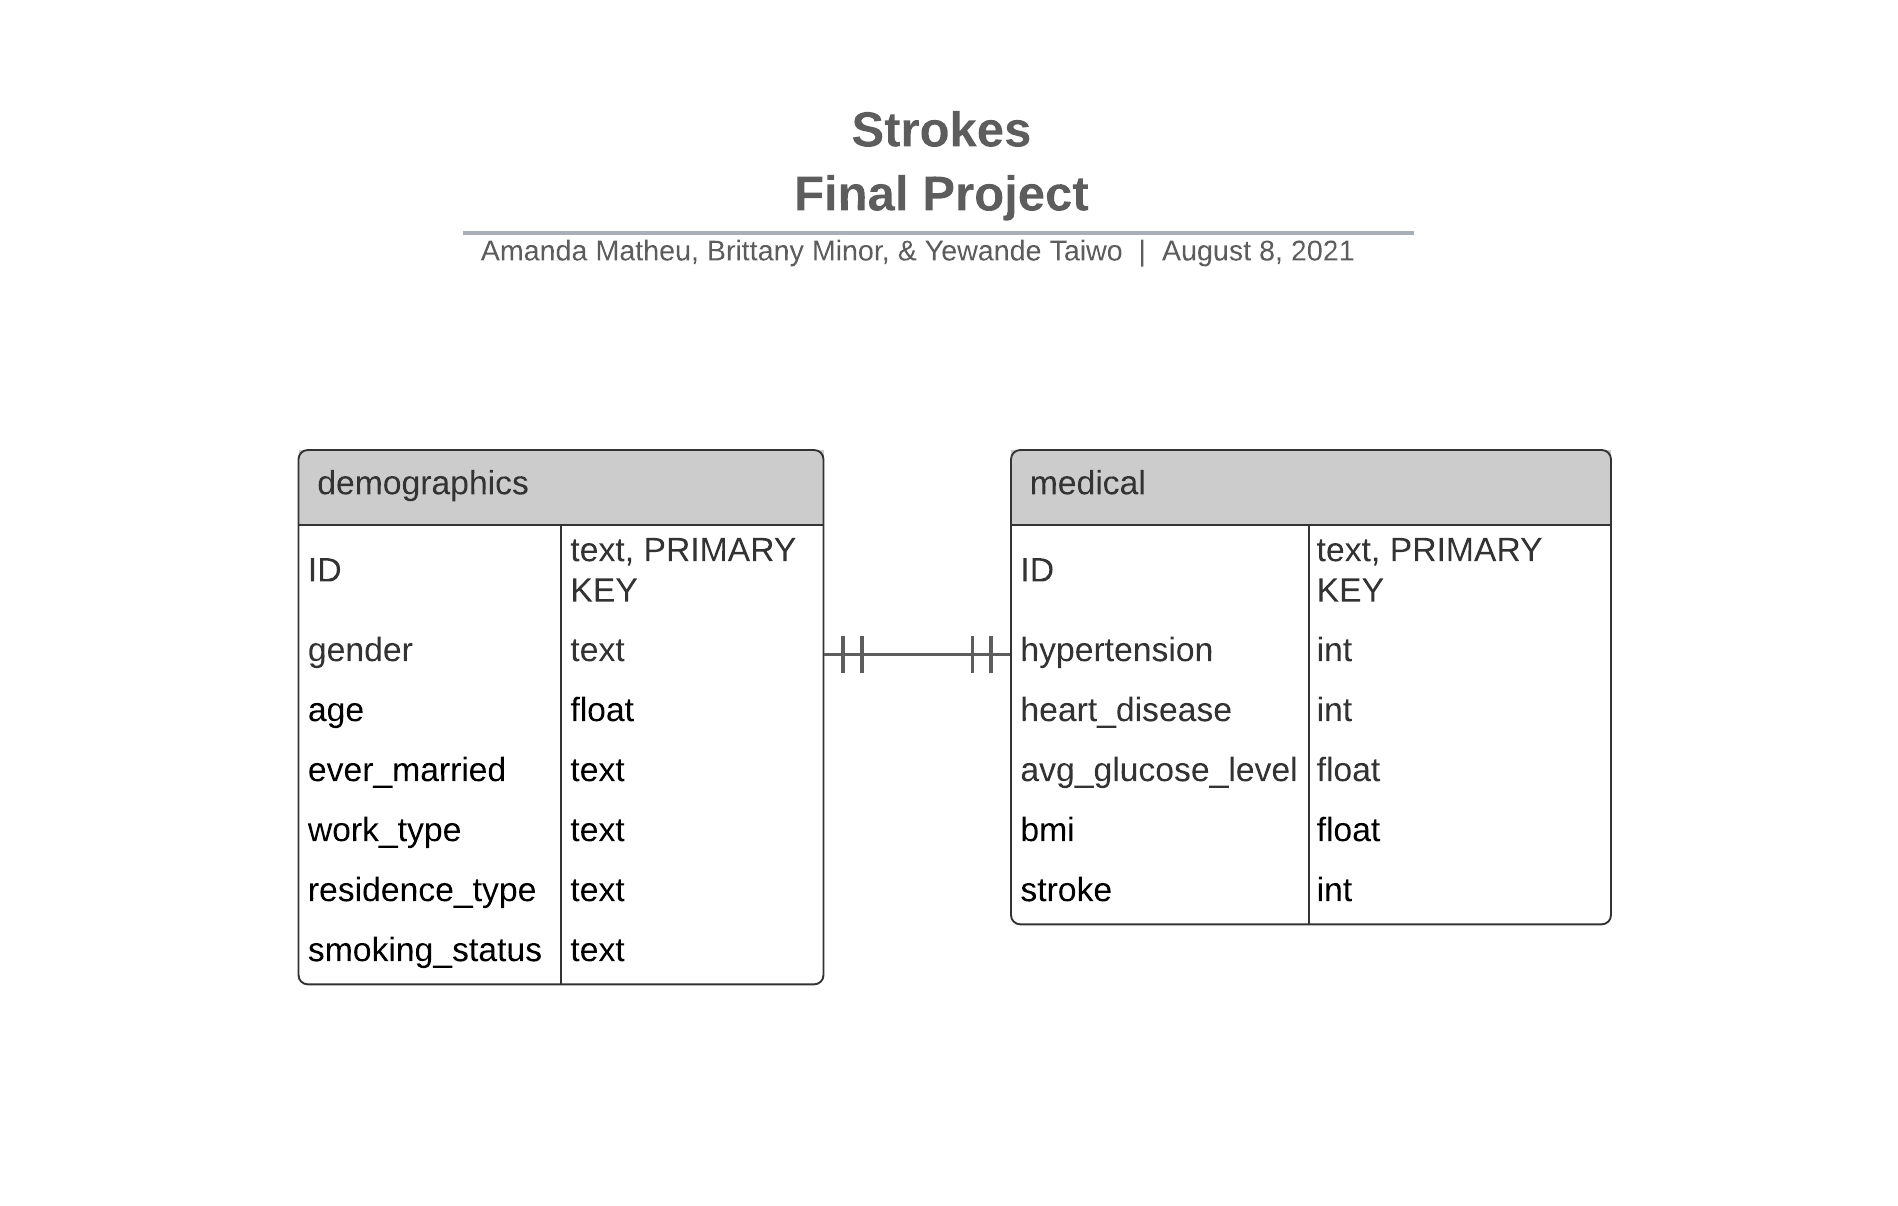

In [1]:
from IPython.display import Image
Image(filename='Stroke_db_chart.png') 